In [1]:
from jqdata import *
from jqlib.technical_analysis import *
from jqfactor import get_factor_values
from jqfactor import winsorize
from jqfactor import standardlize
from jqfactor import neutralize
import datetime
import pandas as pd
import numpy as np
import pickle
from six import StringIO
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint 
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Data Set Preperation

In [3]:
#read train data
train_data=pd.read_csv('train_set.csv',index_col=[0])

In [4]:
train_data.head()

,roic_ttm,log_market_cap,pe_ratio,pb_ratio,ps_ratio,roe_ttm,roe_q,roa_ttm,roa_q,gross_profit_margin_ttm,gross_profit_margin_q,profit_margin_q,financial_leverage,debt_to_equity_ratio,cash_ratio,current_ratio,intangible_asset_ratio,total_asset_growth_rate,profit_margin_growth_rate,net_profit_growth_rate,asset_turnover_ttm,asset_turnover_q,operating_revenue_growth_rate,net_operate_cf_growth_rate,contrarian_1m,contrarian_3m,contrarian_6m,contrarian_12m,stock_turnover_1m,stock_turnover_3m,stock_turnover_6m,stock_turnover_12m,bias_stock_turnover_1m,bias_stock_turnover_3m,bias_stock_turnover_6m,bias_stock_turnover_12m,volatility_of_return_1m,volatility_of_return_3m,volatility_of_return_6m,volatility_of_return_12m,sharpe_ratio_20d,sharpe_ratio_60d,sharpe_ratio_120d,pchg,label
600804.XSHG,-0.055995,-0.195735,-0.053428,-0.116181,-0.005641,-0.062522,-0.068488,-0.064927,-0.075975,-0.107351,-0.109912,-0.087277,-0.085980,-0.041941,-0.038178,-0.104063,-0.059347,-0.029840,0.006779,-0.027945,-0.034239,-0.043841,-0.017284,0.008792,2.632294e-18,-0.196095,-0.196095,-0.196095,-0.111905,-0.124008,-0.124254,-0.127046,-0.016064,-0.016436,-0.044982,-0.064437,3.695021e-18,-0.196095,-0.196095,-0.196095,0.005883,-0.036394,-0.054728,0.258065,1
600850.XSHG,1.215566,-2.923471,0.391730,-2.739413,-0.065331,-0.226707,-0.509564,-0.089940,-0.509507,-0.403383,-0.508204,-0.056668,-1.501331,0.296614,-0.045654,-0.943735,-0.984374,1.339353,1.851232,-1.307030,0.342605,-0.303652,0.729783,2.246657,2.632294e-18,-2.874533,-2.874533,-2.874533,-2.288478,-2.785949,-2.418461,-2.469103,-0.880163,-1.575790,-1.464459,-1.755021,3.695021e-18,-2.874533,-2.874533,-2.874533,0.677853,0.597019,0.812800,0.192564,1
600718.XSHG,-1.588165,-1.522499,-0.714094,0.097528,0.680797,-1.762527,-0.957323,-1.592553,-0.610030,-1.522892,-1.474262,-0.652616,-0.970622,1.957193,0.033732,-0.106706,-1.343301,-2.460506,0.517532,-0.795378,-0.065278,-0.447922,-1.321819,0.987280,2.632294e-18,-1.295911,-1.295911,-1.295911,0.328895,0.579287,0.567191,0.857414,-0.598284,-0.432844,-1.147654,0.128769,3.695021e-18,-1.295911,-1.295911,-1.295911,-2.138408,-1.368282,-1.727253,0.147541,1
002153.XSHE,1.662192,0.118909,0.263470,-1.059561,-1.113314,1.202557,0.191793,2.107173,1.138300,1.535847,1.285498,1.626907,-1.022375,-1.117546,-0.668472,0.227600,1.890776,-0.370949,0.673668,-0.377463,-0.727158,-0.912399,0.197201,1.254444,2.632294e-18,0.039920,0.039920,0.039920,-0.517503,-0.698115,-0.798066,-1.114343,2.133129,2.587449,2.879251,0.592217,3.695021e-18,0.039920,0.039920,0.039920,-1.521551,-1.490505,-1.782744,0.147327,1
002253.XSHE,-0.227543,0.476593,0.278858,0.200114,-1.465691,0.297998,-0.559863,0.488940,-0.675715,0.474033,-0.270922,0.490658,-0.766871,-0.141714,0.243918,0.320660,1.709261,-0.409394,-0.195321,0.227160,-2.221092,-1.844938,0.402864,0.109841,2.632294e-18,0.529314,0.529314,0.529314,1.245386,1.187222,1.379396,1.810029,-0.550017,-0.911855,-0.985095,-0.721839,3.695021e-18,0.529314,0.529314,0.529314,-0.512662,-1.051406,0.034480,0.134927,1


In [5]:
#read test data
test_read=open('test_set.pkl','rb')
test_data=pickle.load(test_read)

In [6]:
#combine test data
test_data_2=pd.DataFrame()

for date in test_data:
    if test_data_2.empty:
        test_data_2=test_data[date]
    else:
        test_data_2=test_data_2.append(test_data[date]) 

In [7]:
test_data_2.head()

,roic_ttm,log_market_cap,pe_ratio,pb_ratio,ps_ratio,roe_ttm,roe_q,roa_ttm,roa_q,gross_profit_margin_ttm,gross_profit_margin_q,profit_margin_q,financial_leverage,debt_to_equity_ratio,cash_ratio,current_ratio,intangible_asset_ratio,total_asset_growth_rate,profit_margin_growth_rate,net_profit_growth_rate,asset_turnover_ttm,asset_turnover_q,operating_revenue_growth_rate,net_operate_cf_growth_rate,contrarian_1m,contrarian_3m,contrarian_6m,contrarian_12m,stock_turnover_1m,stock_turnover_3m,stock_turnover_6m,stock_turnover_12m,bias_stock_turnover_1m,bias_stock_turnover_3m,bias_stock_turnover_6m,bias_stock_turnover_12m,volatility_of_return_1m,volatility_of_return_3m,volatility_of_return_6m,volatility_of_return_12m,sharpe_ratio_20d,sharpe_ratio_60d,sharpe_ratio_120d,pchg,label
002544.XSHE,-5.022984e-01,1.049497e+00,-1.888127e-01,-6.399430e-01,8.504566e-01,5.920308e-02,-2.213435e-01,-6.529473e-01,-5.689903e-01,-1.185109e+00,-1.355893e+00,-6.143439e-01,2.572464e+00,4.105988e+00,1.007772e+00,-8.154730e-01,-8.384589e-01,6.097114e-01,-5.878077e-01,1.571231e-01,6.203389e-01,6.557445e-01,-3.612495e-01,1.009402e+00,2.632294e-18,8.116472e-18,0.246516,0.238445,-1.034679e+00,-9.411158e-01,-1.041091e+00,-1.252398e+00,-1.062059e+00,-8.555780e-01,-1.189890e+00,-1.955577e+00,3.695021e-18,-1.475354e-17,-0.258070,-0.237017,-5.790604e-01,1.277415e+00,2.582709e+00,0.501093,1
600571.XSHG,1.401812e+00,-8.332897e-01,2.104128e+00,7.902634e-02,2.548659e+00,1.875647e+00,1.151184e+00,1.197669e+00,7.790262e-01,1.316998e-01,-4.242250e-01,-3.258238e-01,1.002707e+00,-5.643643e-01,6.046129e-01,-1.038395e+00,-3.504898e-01,1.638627e-01,-5.785433e-01,4.099002e-01,2.538284e+00,2.608691e+00,1.245287e+00,8.481272e-01,2.632294e-18,8.116472e-18,-0.566720,-0.632182,-2.095131e+00,-2.388753e+00,-1.839499e+00,-1.787597e+00,-1.885129e+00,-2.050315e+00,-1.496040e+00,-7.554289e-01,3.695021e-18,-1.475354e-17,0.594047,0.580432,1.621751e-01,1.273738e-01,-8.488949e-01,0.363830,1
000835.XSHE,1.015958e-14,5.388252e-13,1.053967e-14,2.253928e-14,7.321741e-15,9.377215e-15,4.339256e-15,9.847329e-15,5.369509e-15,1.791791e-14,1.153644e-14,5.136135e-15,-9.581395e-16,-7.738055e-15,-5.900501e-15,1.118026e-14,4.491168e-15,-3.178030e-15,-6.883425e-15,2.916810e-15,1.012175e-14,1.623421e-14,5.045425e-15,-2.319906e-15,2.632294e-18,8.116472e-18,-0.992701,-1.067495,1.684032e-14,1.790739e-14,1.792415e-14,1.824165e-14,1.937198e-15,-3.348458e-15,-6.505017e-15,-6.975548e-15,3.695021e-18,-1.475354e-17,0.968979,1.034570,-1.734827e-16,6.166797e-16,-2.786227e-17,0.256881,1
002555.XSHE,1.954749e-15,2.152131e-13,1.253206e-15,4.901191e-15,1.554894e-15,1.918067e-15,8.094718e-16,2.604446e-15,1.251756e-15,4.574109e-15,5.885211e-15,1.033855e-15,8.207343e-15,3.715722e-15,1.513525e-16,3.705737e-15,9.776692e-16,1.713342e-15,4.020811e-16,-1.054047e-15,5.127713e-15,2.441673e-15,6.725264e-16,-1.487782e-15,2.632294e-18,8.116472e-18,-0.527995,-0.507806,4.024021e-15,4.404305e-15,4.935919e-15,2.971289e-15,-8.645345e-16,6.577874e-16,-1.453635e-16,-2.081277e-15,3.695021e-18,-1.475354e-17,0.457709,0.459328,1.024533e-15,1.782295e-15,3.965329e-15,0.221325,1
002268.XSHE,7.905162e-02,9.283960e-01,-5.831444e-01,-1.406281e+00,-6.968963e-01,-5.013389e-02,3.193120e-01,8.972816e-02,6.392626e-01,4.129461e-01,6.963943e-01,-3.278233e-01,-1.363794e-01,1.461197e-01,-7.921236e-01,-5.039734e-01,-9.912978e-01,-7.031866e-01,-7.479868e-01,2.615207e+00,5.670692e-01,3.822049e-01,1.209718e+00,-6.852115e-02,2.632294e-18,8.116472e-18,0.091614,0.082976,-1.230127e+00,-1.175732e+00,-1.290432e+00,-1.193096e+00,-9.806871e-01,-7.060195e-01,-1.064717e+00,-1.195971e+00,3.695021e-18,-1.475354e-17,-0.087646,-0.085638,-5.807672e-01,-3.821598e-01,2.611708e-01,0.216561,1


In [10]:
test_data_2.to_csv('test_set_combined.csv')

In [11]:
test_data_combined=pd.read_csv('test_set_combined.csv',index_col=0)

In [12]:
test_data_combined.head()

,roic_ttm,log_market_cap,pe_ratio,pb_ratio,ps_ratio,roe_ttm,roe_q,roa_ttm,roa_q,gross_profit_margin_ttm,gross_profit_margin_q,profit_margin_q,financial_leverage,debt_to_equity_ratio,cash_ratio,current_ratio,intangible_asset_ratio,total_asset_growth_rate,profit_margin_growth_rate,net_profit_growth_rate,asset_turnover_ttm,asset_turnover_q,operating_revenue_growth_rate,net_operate_cf_growth_rate,contrarian_1m,contrarian_3m,contrarian_6m,contrarian_12m,stock_turnover_1m,stock_turnover_3m,stock_turnover_6m,stock_turnover_12m,bias_stock_turnover_1m,bias_stock_turnover_3m,bias_stock_turnover_6m,bias_stock_turnover_12m,volatility_of_return_1m,volatility_of_return_3m,volatility_of_return_6m,volatility_of_return_12m,sharpe_ratio_20d,sharpe_ratio_60d,sharpe_ratio_120d,pchg,label
002544.XSHE,-5.022984e-01,1.049497e+00,-1.888127e-01,-6.399430e-01,8.504566e-01,5.920308e-02,-2.213435e-01,-6.529473e-01,-5.689903e-01,-1.185109e+00,-1.355893e+00,-6.143439e-01,2.572464e+00,4.105988e+00,1.007772e+00,-8.154730e-01,-8.384589e-01,6.097114e-01,-5.878077e-01,1.571231e-01,6.203389e-01,6.557445e-01,-3.612495e-01,1.009402e+00,2.632294e-18,8.116472e-18,0.246516,0.238445,-1.034679e+00,-9.411158e-01,-1.041091e+00,-1.252398e+00,-1.062059e+00,-8.555780e-01,-1.189890e+00,-1.955577e+00,3.695021e-18,-1.475354e-17,-0.258070,-0.237017,-5.790604e-01,1.277415e+00,2.582709e+00,0.501093,1
600571.XSHG,1.401812e+00,-8.332897e-01,2.104128e+00,7.902634e-02,2.548659e+00,1.875647e+00,1.151184e+00,1.197669e+00,7.790262e-01,1.316998e-01,-4.242250e-01,-3.258238e-01,1.002707e+00,-5.643643e-01,6.046129e-01,-1.038395e+00,-3.504898e-01,1.638627e-01,-5.785433e-01,4.099002e-01,2.538284e+00,2.608691e+00,1.245287e+00,8.481272e-01,2.632294e-18,8.116472e-18,-0.566720,-0.632182,-2.095131e+00,-2.388753e+00,-1.839499e+00,-1.787597e+00,-1.885129e+00,-2.050315e+00,-1.496040e+00,-7.554289e-01,3.695021e-18,-1.475354e-17,0.594047,0.580432,1.621751e-01,1.273738e-01,-8.488949e-01,0.363830,1
000835.XSHE,1.015958e-14,5.388252e-13,1.053967e-14,2.253928e-14,7.321741e-15,9.377215e-15,4.339256e-15,9.847329e-15,5.369509e-15,1.791791e-14,1.153644e-14,5.136135e-15,-9.581395e-16,-7.738055e-15,-5.900501e-15,1.118026e-14,4.491168e-15,-3.178030e-15,-6.883425e-15,2.916810e-15,1.012175e-14,1.623421e-14,5.045425e-15,-2.319906e-15,2.632294e-18,8.116472e-18,-0.992701,-1.067495,1.684032e-14,1.790739e-14,1.792415e-14,1.824165e-14,1.937198e-15,-3.348458e-15,-6.505017e-15,-6.975548e-15,3.695021e-18,-1.475354e-17,0.968979,1.034570,-1.734827e-16,6.166797e-16,-2.786227e-17,0.256881,1
002555.XSHE,1.954749e-15,2.152131e-13,1.253206e-15,4.901191e-15,1.554894e-15,1.918067e-15,8.094718e-16,2.604446e-15,1.251756e-15,4.574109e-15,5.885211e-15,1.033855e-15,8.207343e-15,3.715722e-15,1.513525e-16,3.705737e-15,9.776692e-16,1.713342e-15,4.020811e-16,-1.054047e-15,5.127713e-15,2.441673e-15,6.725264e-16,-1.487782e-15,2.632294e-18,8.116472e-18,-0.527995,-0.507806,4.024021e-15,4.404305e-15,4.935919e-15,2.971289e-15,-8.645345e-16,6.577874e-16,-1.453635e-16,-2.081277e-15,3.695021e-18,-1.475354e-17,0.457709,0.459328,1.024533e-15,1.782295e-15,3.965329e-15,0.221325,1
002268.XSHE,7.905162e-02,9.283960e-01,-5.831444e-01,-1.406281e+00,-6.968963e-01,-5.013389e-02,3.193120e-01,8.972816e-02,6.392626e-01,4.129461e-01,6.963943e-01,-3.278233e-01,-1.363794e-01,1.461197e-01,-7.921236e-01,-5.039734e-01,-9.912978e-01,-7.031866e-01,-7.479868e-01,2.615207e+00,5.670692e-01,3.822049e-01,1.209718e+00,-6.852115e-02,2.632294e-18,8.116472e-18,0.091614,0.082976,-1.230127e+00,-1.175732e+00,-1.290432e+00,-1.193096e+00,-9.806871e-01,-7.060195e-01,-1.064717e+00,-1.195971e+00,3.695021e-18,-1.475354e-17,-0.087646,-0.085638,-5.807672e-01,-3.821598e-01,2.611708e-01,0.216561,1


In [60]:
# get features and labels from test data
test_target=test_data_combined['label']
test_feature=test_data_combined.copy()
del test_feature['pchg']
del test_feature['label']

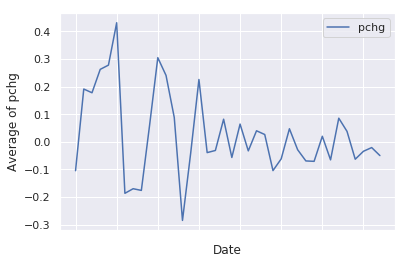

In [97]:
date_temp = list(test_data.keys())
pchg_list=[]

for date in test_data:
    pchg_avg=mean(list(test_data[date]['pchg']))
    pchg_list.append(pchg_avg)

data = {'date': date_temp, 'pchg':pchg_list}

date_hist = pd.DataFrame(data, columns=['date', 'pchg'])

date_hist.plot.line(x='date', y='pchg')

plt.ylabel('Average of pchg')
plt.xlabel('Date')
plt.savefig('avg_pchg_test.jpg')


## Correlation Plot

On every cross section(date), compute the correlation coefficients of $\textit{the predicted return of each stock next period}$ and $\textit{the factor values current period}$.

The plot shows the actual relationship: every row corresponds to one specific factor. The more average the color is, the smaller the volatility is. That is because we are only changing the values of input factors out of the sample, rather than changing how we use the factorsk;thus, the correlation is more stable. 

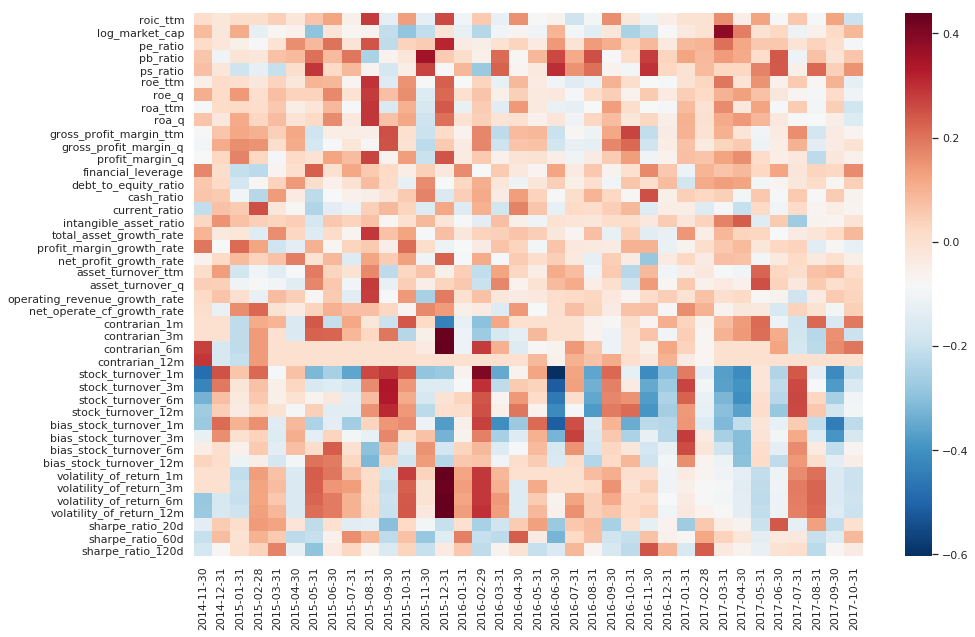

In [20]:
factor_predict_corr=pd.DataFrame()
for date in list(test_data.keys())[:-2]:
    test_feature_temp=test_data[date].copy()
    del test_feature_temp['pchg']
    factor_predict_corr[date]=test_feature_temp.corr()['label']    
factor_predict_corr=factor_predict_corr.iloc[:-1]

#correlation plot : predicted return of next period & factor values of this current period
fig = plt.figure(figsize= (15,10))
ax = fig.add_subplot(111)
sns.set()
ax = sns.heatmap(factor_predict_corr,cmap="RdBu_r")
plt.savefig('correlation_plot.jpg')

## Model

## 1. SVM

### 1.1 SVM-SVC

In [15]:
train_target=train_data['label']
train_feature=train_data.copy()
del train_feature['pchg']
del train_feature['label']

regressor = svm.SVC()

parameters = {'kernel':['rbf'],'C':[0.01,0.03,0.1,0.3,1,3,10],\
              'gamma':[0.01, 0.03, 0.1, 0.3, 1,3,10]}

grid_search = GridSearchCV(regressor,parameters,cv=5,return_train_score=True)
grid_search.fit(train_feature,train_target)


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
# result list 
#print (grid_search.cv_results_)
# result of each model
#print (grid_search.grid_scores_)
# Best cross-validation score
print (grid_search.best_score_)
# Best parameters
print (grid_search.best_params_)

0.5405750798722044
{'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}


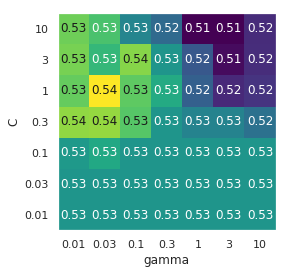

In [17]:
results = pd.DataFrame(grid_search.cv_results_)
import matplotlib.pyplot as plt
scores = np.array(results.mean_test_score).reshape(7,7)

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

heatmap(scores, xlabel='gamma', xticklabels=parameters['gamma'],
                      ylabel='C', yticklabels=parameters['C'], cmap="viridis")

In [18]:
#iterations
m=5

train_score=[]
test_score=[]

clf = svm.SVC(C=1,gamma=0.03,kernel='rbf')

for i in range(m):
    #random 20% for validation set
    X_train,X_test, y_train, y_test =train_test_split(train_feature,train_target,test_size=0.2)                                                   
    # train the model
    clf.fit(X_train,y_train)
    # predict the model
    train_predict=clf.predict(X_train)
    test_predict=clf.predict(X_test)
    #test_hinge=hinge_loss(y_test,test_predict)
    # train set accuracy score
    train_score.append(clf.score(X_train, y_train))
    # validation set accuracy score
    test_score.append(clf.score(X_test, y_test))

    
print ('train set accuracy score:',mean(train_score))
print ('validation set accuracy score:',mean(test_score))
print ('total train set accuracy score:',clf.score(train_feature, train_target))

train set accuracy score: 0.7382854100106496
validation set accuracy score: 0.5441959531416402
total train set accuracy score: 0.6984025559105431


In [22]:
# test set
clf.fit(train_feature,train_target)

print ('test set accuracy score:',clf.score(test_feature, test_target))

test set accuracy score: 0.5471535982814179


## 2. Logistic Regression

In [23]:
# #Logistic Regression
from sklearn.metrics import log_loss

cval = [0.0001, 0.001, 1,10, 100, 1000] 
for c in cval: 
    log_reg = LogisticRegression(C=c, solver='lbfgs', max_iter = 10000)
    log_reg.fit(train_feature,train_target)
    acc_5cv = np.mean(cross_val_score(log_reg, train_feature, train_target, cv=5))
    print (c,acc_5cv)
#choose best lamda value with highest accuracy as complexity parameter
#0.001

0.0001 0.5290734824281149
0.001 0.5326943556975505
1 0.531629392971246
10 0.5305644302449414
100 0.5305644302449414
1000 0.5305644302449414


In [24]:
m=5

train_score=[]
test_score=[]
train_auc=[]
test_auc=[]

log_reg = LogisticRegression(C=0.001, solver='lbfgs', max_iter = 10000)

for i in range(m):
    #random 20% for validation set
    X_train,X_test, y_train, y_test =train_test_split(train_feature,train_target,test_size=0.2)                                                   
    # train the model
    log_reg.fit(X_train,y_train)
    # predict the model
    train_predict=log_reg.predict(X_train)
    test_predict=log_reg.predict(X_test)
    # train set accuracy score
    train_score.append(log_reg.score(X_train, y_train))
    # validation set accuracy score
    test_score.append(log_reg.score(X_test, y_test))
#     print(i)
#     print(log_reg.score(X_train, y_train))
#     print(log_reg.score(X_test, y_test))
    
print ('train set accuracy score:',mean(train_score))
print ('test set accuracy score:',mean(test_score))
print ('total train set accuracy score:',log_reg.score(train_feature, train_target))

train set accuracy score: 0.5619808306709265
test set accuracy score: 0.5433439829605964
total train set accuracy score: 0.5529286474973376


In [17]:
log_reg.fit(train_feature_log,train_target_log)

log_loss(train_target_log, log_reg.predict(train_feature_log))

15.14712204409881

In [26]:
# features and label
print ('test set accuracy score:',log_reg.score(test_feature, test_target))
print('test set AUC：',metrics.roc_auc_score(test_target,log_reg.predict(test_feature)))
print('test set log loss：',log_loss(test_target, log_reg.predict(test_feature)))

test set accuracy score: 0.5484425349087003
test set AUC： 0.5356467826545788
test set log loss： 15.596323907815595


In [27]:
conf_mtx = metrics.confusion_matrix(test_target, log_reg.predict(test_feature))
conf_mtx_df = pd.DataFrame(conf_mtx.T, columns=['(True) p', '(True) n'], index=['[Predicted] Y', '[Predicted] N'])
conf_mtx_df

,(True) p,(True) n
[Predicted] Y,1963,1627
[Predicted] N,475,590


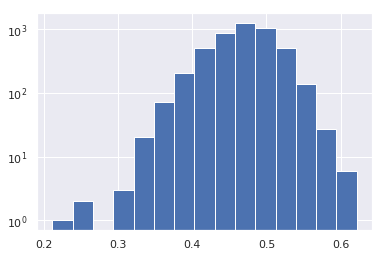

In [28]:
# Get probabilities that an item belongs to class=1
probabilities = log_reg.predict_proba(test_feature)[:, 1]

plt.figure()
plt.hist(probabilities, bins=15, range=(min(probabilities), max(probabilities)), log=True)
plt.show()
#no need to adjust the threshold

## 3. Random Forest

In [30]:
forest  = RandomForestClassifier()
X_train_rf,X_test_rf, y_train_rf, y_test_rf =train_test_split(train_feature,train_target,test_size=0.2)                                                   


param_dist = {
   'n_estimators'     :  sp_randint(1,100),
   'max_features'     :  sp_randint(1,X_train_rf.shape[1]),
   'min_samples_leaf' :  sp_randint(500,5000)
}

random_search = RandomizedSearchCV(
    forest, 
    param_distributions = param_dist,
    cv           = TimeSeriesSplit(5),    
    n_iter       = 1000,
    random_state = 0    
)

random_search.fit(X_train_rf, y_train_rf)
random_search.best_params_

{'max_features': 12, 'min_samples_leaf': 591, 'n_estimators': 50}

In [31]:
forest = RandomForestClassifier(
    random_state     = 0,
    n_estimators     = random_search.best_params_["n_estimators"], 
    max_features     = random_search.best_params_["max_features"],
    min_samples_leaf = random_search.best_params_["min_samples_leaf"])
forest.fit(X_train_rf, y_train_rf);

In [32]:
print("RandomForest log-loss in validation set: %.4f" % log_loss(y_test_rf, forest.predict(X_test_rf), eps=1e-15, normalize=True, sample_weight=None, labels=None))
print("RandomForest log-loss in test dataset: %.4f" % log_loss(test_target, forest.predict(test_feature), eps=1e-15, normalize=True, sample_weight=None, labels=None))

RandomForest log-loss in validation set: 14.7131
RandomForest log-loss in test dataset: 15.4034


In [33]:
print ('train set accuracy score:',forest.score(X_train_rf, y_train_rf))
print ('validation set accuracy score:',forest.score(X_test_rf, y_test_rf))
print ('total train set accuracy score:',forest.score(train_feature, train_target))
print ('test set accuracy score:',forest.score(test_feature, test_target))


train set accuracy score: 0.5625665601703941
validation set accuracy score: 0.5740149094781682
total train set accuracy score: 0.5648562300319488
test set accuracy score: 0.5540279269602578


In [34]:
conf_mtx = metrics.confusion_matrix(test_target, forest.predict(test_feature))
conf_mtx_df = pd.DataFrame(conf_mtx.T, columns=['(True) p', '(True) n'], index=['[Predicted] Y', '[Predicted] N'])
conf_mtx_df

,(True) p,(True) n
[Predicted] Y,1833,1471
[Predicted] N,605,746


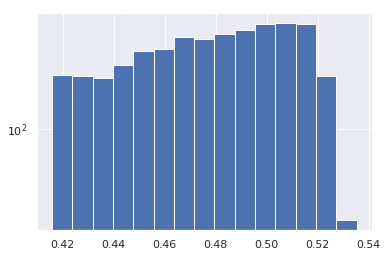

In [35]:
# Get probabilities that an item belongs to class=1
probabilities = forest.predict_proba(test_feature)[:, 1]

plt.figure()
plt.hist(probabilities, bins=15, range=(min(probabilities), max(probabilities)), log=True)
plt.show()
#no need to adjust the threshold

## 4. Ensemble Method 

In [36]:
X_train_en,X_test_en, y_train_en, y_test_en =train_test_split(train_feature,train_target,test_size=0.2)              

In [40]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[10,20,30]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train_en,y_train_en)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.53941, std: 0.01029, params: {'learning_rate': 0.15, 'n_estimators': 10},
  mean: 0.54128, std: 0.00956, params: {'learning_rate': 0.15, 'n_estimators': 20},
  mean: 0.53941, std: 0.00647, params: {'learning_rate': 0.15, 'n_estimators': 30},
  mean: 0.53088, std: 0.01327, params: {'learning_rate': 0.1, 'n_estimators': 10},
  mean: 0.54180, std: 0.00898, params: {'learning_rate': 0.1, 'n_estimators': 20},
  mean: 0.53780, std: 0.00803, params: {'learning_rate': 0.1, 'n_estimators': 30},
  mean: 0.53435, std: 0.01170, params: {'learning_rate': 0.05, 'n_estimators': 10},
  mean: 0.53621, std: 0.00922, params: {'learning_rate': 0.05, 'n_estimators': 20},
  mean: 0.54127, std: 0.00575, params: {'learning_rate': 0.05, 'n_estimators': 30},
  mean: 0.52556, std: 0.00033, params: {'learning_rate': 0.01, 'n_estimators': 10},
  mean: 0.52716, std: 0.00321, params: {'learning_rate': 0.01, 'n_estimators': 20},
  mean: 0.53088, std: 0.00378, params: {'learning_rate': 0.01, 'n_estimators': 

In [41]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
gb.fit(X_train_en, y_train_en)
predictions = gb.predict(test_feature)

print("Confusion Matrix:")
print(confusion_matrix(test_target, predictions))
print()
print("Classification Report")
print(classification_report(test_target, predictions))

Confusion Matrix:
[[1726 712]
 [1387 830]]

Classification Report
             precision    recall  f1-score   support

         -1       0.55      0.71      0.62      2438
          1       0.54      0.37      0.44      2217

avg / total       0.55      0.55      0.54      4655



In [42]:
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_en, y_train_en)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_en, y_test_en)))
print("Accuracy score (total training set): {0:.3f}".format(gb.score(train_feature, train_target)))
print("Accuracy score (test set): {0:.3f}".format(gb.score(test_feature, test_target)))


Accuracy score (training): 0.682
Accuracy score (validation): 0.548
Accuracy score (total training set): 0.655
Accuracy score (test set): 0.549
